# Unsupervised Goal Space Learning Notebook

In this notebook, we provide the necessary elements to reproduce (and criticize!) the results of the paper:
>Unsupervised Learning of Goal Spaces for Intrinsically Motivated Exploration



In [1]:
import sys
sys.path.append("src")
import experiment
import environments
import rendering
import embeddings
import utils
import exploration
import measures

import networkx
if networkx.__version__ == "2.0":
    print("Please install an anterior version of networkx like 1.9")
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import scipy.stats
import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [2]:
NB_POINTS_MANIFOLD_MEASURES = int(1e3)
NB_SAMPLES_MSE = int(1e2)
NB_SAMPLES_TRAINING = int(1e4)
NB_BINS_EXPLORATION = 10
NB_ITERATIONS_EXPLORATION = int(5e3)
EXPLORATION_RATIO = 0.05
EMBEDDING_SIZE = 10


EXPLORATION_CALLBACK_PERIOD = int(1e1)
LOGS_PATH = "logs"

First, we define the parameters of the experiment:

In [3]:
def generate_params(environment, exploration_algorithm):
    """
    This function generates the parameters of the experiment according to the given inputs.
    """

    # We instantiate the parameters dict
    params = dict()
    # Depending on the environment, we set some parameters
    if environment=="armball":
        params['env_config'] = dict(m_mins=[-1.] * 7, m_maxs=[1.] * 7, s_mins=[-1.] * EMBEDDING_SIZE, 
                                    s_maxs=[1.] * EMBEDDING_SIZE, arm_lengths=[0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05], 
                                    arm_angle_shift=0.5, arm_rest_state=[0.] * 7, ball_size=0.1, 
                                    ball_initial_position=[0.6, 0.6])
        params['env'] = environments.ArmBallDynamic
        params['renderer'] = rendering.ArmBallRenderer
    elif environment=='armarrow':
        params['env_config'] = dict(m_mins=[-1.] * 7, m_maxs=[1.] * 7, s_mins=[-1.] * EMBEDDING_SIZE, 
                                    s_maxs=[1.] * EMBEDDING_SIZE, arm_lengths=[0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05], 
                                    arm_angle_shift=0.5, arm_rest_state=[0.] * 7, arrow_size=0.1, 
                                    arrow_initial_pose=[0.6, 0.6, 0.6])
        params['env'] = environments.ArmArrowDynamic
        params['renderer'] = rendering.ArmArrowRenderer
    # Depending on the model, we set other parameters
    if exploration_algorithm =='RGE-VAE':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = embeddings.VariationalAutoEncoderEmbedding
        params['belief'] = 'normal'
    elif exploration_algorithm =='RGE-AE':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = embeddings.AutoEncoderEmbedding
        params['belief'] = 'kde'
    elif exploration_algorithm =='RGE-RFVAE':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = embeddings.RadialVariationalAutoEncoderEmbedding
        params['belief'] = 'normal'
    elif exploration_algorithm =='RGE-ISOMAP':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = embeddings.IsomapEmbedding
        params['belief'] = 'kde'
    elif exploration_algorithm =='RGE-PCA':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = embeddings.PcaEmbedding
        params['belief'] = 'kde'
    elif exploration_algorithm =='RGE-FI':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = 'state'
        params['belief'] = 'uniform'
    elif exploration_algorithm =='RPE':
        params['emb_size'] = EMBEDDING_SIZE
        params['embedding'] = 'none'
        params['belief'] = 'uniform'
    
    return params

In [10]:
explo = 'RGE-FI' # 'RGE'AE', 'RGE-VAE', 'RGE-RFVAE', 'RGE-ISOMAP', 'RGE-PCA', 'RGE-FI', 'RPE'
env = 'armarrow' # 'armball', 'armarrow'
params = generate_params(environment=env, exploration_algorithm=explo)

We instantiate the environment:

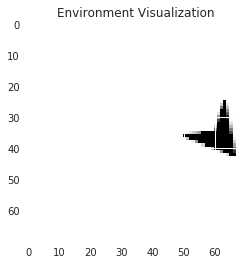

In [11]:
# We set the environment configuration
environment_config = params['env_config']
# We instantiate the environment
environment = params['env'](environment_config, n_dmp_basis=3, goal_size=1.)
# We instantiate the renderer
renderer = params['renderer']()
# We render a random state
plt.imshow(renderer.sample(nb_samples=1).squeeze(), cmap="Greys")
plt.title("Environment Visualization");

We train the representation learning algorithm, if any:

In [12]:
# We train the embedding
if params['embedding'] not in ['none', 'state']:
    # We sample the environment state space
    X = renderer.sample(nb_samples=NB_SAMPLES_TRAINING)
    # We instantiate the embedding
    embedder = params['embedding'](emb_size=params['emb_size'], logs_path=LOGS_PATH)
    # We train the model
    embedder.fit(X)
    loss, log_likelihood = embedder.get_training_data()
    print("Achieved Loss: %s"%str(loss))
    print("Achieved Log-likelihood: %s"%str(log_likelihood))
else:
    params['emb_size'] = renderer.nb_params()

In [13]:
# We measure quality
if params['embedding'] is not 'none':
    # We sample random environment states
    samples_states = np.random.uniform(size=[NB_POINTS_MANIFOLD_MEASURES, renderer.nb_params()])
    # We project them on an embedded manifold so that the k-neighbors graph is well behaved
    samples_geodesics = utils.manifold_2_space_coordinates(samples_states, renderer.get_factor_dims())
    # We construct the images and project into latent space
    if params['embedding'] is 'state':
        samples_latents = samples_states
        training_latents = np.random.uniform(size=[NB_POINTS_MANIFOLD_MEASURES, renderer.nb_params()])
    else:
        samples_images = np.array([renderer.draw(state) for state in samples_states])
        samples_latents = embedder.transform(samples_images)
        training_latents = embedder.transform(X)
    # We compute various quality measures
    local_qual = measures.embedding_local_quality(samples_geodesics, samples_latents)
    global_qual = measures.embedding_global_quality(samples_geodesics, samples_latents)
    print("Local Quality Measures:\n")
    pp.pprint(local_qual)
    print("\n Global Quality Measures:\n")
    pp.pprint(global_qual)

Local Quality Measures:

{   'bnx': [0.059428571428571442],
    'btc': [0.022519917256759392],
    'continuity': [0.97552830447567285],
    'extrusion': [0.46257142857142858],
    'intrusion': [0.52200000000000002],
    'lcmc': [0.72057069952861541],
    'mrre_continuity': [0.0006719715847097994],
    'mrre_trustworthiness': [0.00079761664515927303],
    'protrusion': [0.25771428571428573],
    'qmrre': [1.9985304117701308],
    'qnx': [0.72685714285714287],
    'qtc': [1.9735765262081051],
    'trustworthiness': [0.99804822173243224]}

 Global Quality Measures:

{   'empirical_distorsion': 401.51300489187287,
    'kruskal_stress': 0.26884315028748318,
    'quadratic_loss': 317835.88425592904,
    'residual_variance': -2.0078800403635131,
    's_stress': 0.0,
    'sammon_stress': 0.29671195077413154}


In [14]:
# We define the transformation method used during exploration
def transform_method(s):
    if params['embedding'] not in ['state', 'none']:
        s = (s+1.)/2.
        image = renderer.draw(s)
        latent = embedder.transform(image.reshape([1,-1])).squeeze()
    else:
        latent = (s+1.)/2.

    return latent

# We define the sampling method used during exploration
def sampling_method():
    if params['belief'] == 'uniform':
        sample = np.random.uniform(size=[1, params['emb_size']])
    elif self._params['belief'] == 'normal':
        sample = np.random.randn(1, params['emb_size'])
    elif self._params['belief'] == 'kde':
        sample = kde.resample(size=1).squeeze()
    return sample.ravel()

# We instantiate the exploration algorithm
if not params['embedding'] is 'none':
    explorator = exploration.GoalBabblingExploration(environment=environment,
                                                     explo_ratio=EXPLORATION_RATIO,
                                                     emb_size=params['emb_size'],
                                                     transform_method=transform_method,
                                                     sampling_method=sampling_method,
                                                     callback_period=EXPLORATION_CALLBACK_PERIOD)
else:
    explorator = exploration.RandomMotorBabblingExploration(environment=environment,
                                                            explo_ratio = EXPLORATION_RATIO,
                                                            emb_size=params['emb_size'],
                                                            transform_method=transform_method,
                                                            sampling_method=sampling_method,
                                                            callback_period=EXPLORATION_CALLBACK_PERIOD)

# We set the running measures lists
exploration_list = []
mse_list = []

# We define the callback method used during exploration
def callback_method():
    # We append measures
    mse_list.append(measures.model_mse(explorator, nb_samples=NB_SAMPLES_MSE))
    exploration_list.append(measures.exploration(explorator, bins=NB_BINS_EXPLORATION))

# We set the callback method
explorator.set_callback(callback_method=callback_method)

In [15]:
# We perform the exploration
explorator.explore(nb_iterations=NB_ITERATIONS_EXPLORATION)

A Jupyter Widget

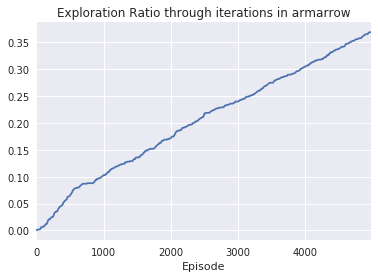

In [17]:
# We plot the Exploration Ratio through iterations
axes = sns.tsplot(time=pd.Series(data=np.array(range(len(exploration_list)))*EXPLORATION_CALLBACK_PERIOD,
                                 name="Episode"),
                  data=pd.Series(data=exploration_list, name="Exploration Ratio"))

plt.title("Exploration Ratio through iterations in %s"%env)
plt.show()

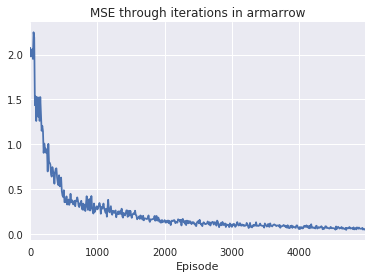

In [18]:
# We plot the Exploration Ratio through iterations
axes = sns.tsplot(time=pd.Series(data=np.array(range(len(mse_list)))*EXPLORATION_CALLBACK_PERIOD, name="Episode"),
                  data=pd.Series(data=mse_list, name="MSE"))

plt.title("MSE through iterations in %s"%env)
plt.show()

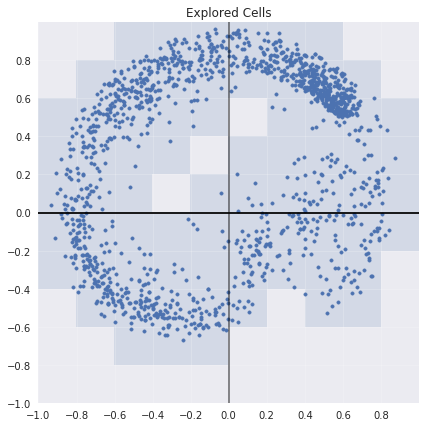

In [19]:
# We plot explored cells
reached = np.array(explorator.get_reached_states())
h, _, _ = np.histogram2d(reached[:,0], reached[:,1],bins=10, range=[(-1,1), (-1,1)])
h[h!=0.] = 1.
plt.figure(figsize=(7,7))
plt.xticks(np.arange(-1,1,2./10.))
plt.yticks(np.arange(-1,1,2./10.))
plt.grid(alpha=.2)
plt.scatter(reached[:,0], reached[:,1],marker=".")
plt.imshow(np.rot90(h), alpha=.1, extent = (-1,1,-1,1), cmap="GnBu")
plt.axhline(0., c="black")
plt.axvline(0., c="black", alpha=.5)
plt.title("Explored Cells");